In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib import pyplot as plt

In [21]:

class Perceptron:
    def __init__(self, num_features, hidden_layers, num_classes, activations, loss_function):
        self.num_features = num_features
        self.activations = activations
        self.loss_function = loss_function
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes
        self.num_layers = len(hidden_layers) + 1
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.history = None
        self._init_params()

    def _init_params(self):
        self.W.append(np.random.rand(self.hidden_layers[0], self.num_features))  # input - hidden
        first_hidden = 0
        last_hidden = self.num_layers - 2
        for i in range(first_hidden, last_hidden):
            self.W.append(np.random.rand(self.hidden_layers[i + 1], self.hidden_layers[i]))
        # self.W.append(np.random.rand(self.hidden_layers[1], self.hidden_layers[0]))
        # self.W.append(np.random.rand(self.hidden_layers[2], self.hidden_layers[1]))
        self.W.append(np.random.rand(self.num_classes, self.hidden_layers[last_hidden]))  # hidden - output

        for i in range(first_hidden, last_hidden + 1):
            self.B.append(np.random.rand(self.hidden_layers[i]))
        # self.B.append(np.random.rand(self.hidden_layers[0])) # first hidden
        # self.B.append(np.random.rand(self.hidden_layers[1]))
        # self.B.append(np.random.rand(self.hidden_layers[2])) # last hidden
        self.B.append(np.random.rand(self.num_classes))  # output

        for _ in range(self.num_layers):
            # create list placeholders for Z and A
            self.Z.append(None)
        for _ in range(self.num_layers - 1):
            self.A.append(None)
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    def predict_sample(self, X):
        Z0 = np.dot(self.W[0], X) + self.B[0]
        self.Z[0] = Z0
        A0 = self.activations[0](Z0)
        self.A[0] = A0

        # Z1 = np.dot(self.W[1], A0) + self.B[1]
        # self.Z[1] = Z1
        # A1 = self.activations[1](Z1)
        # self.A[1] = A1
        #
        # Z2 = np.dot(self.W[2], A1) + self.B[2]
        # self.Z[2] = Z2
        # A2 = self.activations[2](Z2)
        # self.A[2] = A2

        for i in range(1, self.num_layers - 1):
            Z = np.dot(self.W[i], self.A[i - 1]) + self.B[i]
            self.Z[i] = Z
            A = self.activations[i](Z)
            self.A[i] = A

        Z_last = np.dot(self.W[-1], self.A[-1]) + self.B[-1]
        self.Z[-1] = Z_last
        A_last = self.activations[-1](Z_last)
        return A_last

    def predict_batch(self, X):
        predictions = []
        for element in X:
            predictions.append(self.predict_sample(element))
        return np.array(predictions)

    def train(self, x_train, y_train, x_test, y_test, learning_rate=0.1, epochs=100):
        for epoch in range(epochs):
            total_losses = 0
            for i in range(len(x_train)):
                x_i = np.array(x_train[i])
                Yh = self.predict_sample(x_train[i])
                loss = self.loss_function(y_train[i], Yh)
                total_losses += loss

                last_hidden = self.num_layers - 2
                first_hidden = 1

                # output layer
                dloss_Yh = self.loss_function(y_train[i], Yh, der=True)
                dloss_A3 = dloss_Yh

                dout = self.activations[-1](self.Z[-1], der=True)

                if(dout.size == 9):
                    dloss_Z = np.dot(dloss_A3, dout)
                else:
                    dloss_Z = dloss_A3 * dout   
                    
                dloss_A = np.dot(self.W[-1].T, dloss_Z)
                dloss_W3 = np.kron(dloss_Z, self.A[-1]).reshape(self.num_classes, self.hidden_layers[last_hidden])
                dloss_B3 = dloss_Z

                hd_dloss_Z = []
                hd_dloss_A = []
                hd_dloss_W = []
                hd_dloss_B = []

                for i_hd_lay in reversed(range(first_hidden, last_hidden + 1)):
                    dloss_Z = dloss_A * self.activations[i_hd_lay](self.Z[i_hd_lay], der=True)
                    hd_dloss_Z.insert(0, dloss_Z)
                    dloss_A = np.dot(self.W[i_hd_lay].T, dloss_Z)
                    hd_dloss_A.insert(0, dloss_A)
                    dloss_W1 = np.kron(dloss_Z, self.A[i_hd_lay - 1]).reshape(self.hidden_layers[i_hd_lay],
                                                                              self.hidden_layers[i_hd_lay - 1])
                    hd_dloss_W.insert(0, dloss_W1)
                    dloss_B1 = dloss_Z
                    hd_dloss_B.insert(0, dloss_B1)

                # input layer
                dloss_Z0 = dloss_A * self.activations[0](self.Z[0], der=True)
                dloss_W0 = np.kron(dloss_Z0, x_i).reshape(self.hidden_layers[0], self.num_features)
                dloss_B0 = dloss_Z0

                # output layer
                self.W[-1] -= learning_rate * dloss_W3
                self.B[-1] -= learning_rate * dloss_B3

                # hidden layers
                for i in range(first_hidden, last_hidden):
                    self.W[i + 1] -= learning_rate * hd_dloss_W[i]
                    self.B[i + 1] -= learning_rate * hd_dloss_B[i]
                # input layer
                self.W[0] -= learning_rate * dloss_W0
                self.B[0] -= learning_rate * dloss_B0
            # evaluate the model
            self.history["train_acc"].append(self.score(x_train, y_train))
            self.history["val_acc"].append(self.score(x_test, y_test))
            self.history["train_loss"].append(
                self.loss_function(y_train, self.predict_batch(x_train)) / len(y_train))
            self.history["val_loss"].append(
                self.loss_function(y_test, self.predict_batch(x_test)) / len(y_test))
            if epoch % 50 == 0:
                print(
                    f"epoch: {epoch}; train loss: {self.history['train_loss'][-1]}; val loss: {self.history['val_loss'][-1]}")
                print(f"train acc: {self.history['train_acc'][-1]}; val acc: {self.history['val_acc'][-1]}\n")

    def score(self, X, y):
        predictions = self.predict_batch(X)
        return np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)


def ccategorical_crossentropy(y_true, y_pred, der=False):
    if der:
        return (y_pred - y_true) / y_true.shape
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.sum(y_true * np.log(y_pred))


def sigmoid(x, der=False):
    if der:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))


def softmax(x, der=False):
    if der:
        s = softmax(x)
        return np.diag(s) - np.outer(s, s)
    return (np.exp(x) / np.exp(x).sum())


def relu(x, der=False):
    if der:
        f = np.heaviside(x, 1)
    else:
        f = np.maximum(x, 0)
    return f

In [7]:
X, y = datasets.load_wine(return_X_y=True)
y_cat = []
converter = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
for label in y:
    y_cat.append(np.array(converter[label]))
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)

## 2LP

In [5]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.1022789824225687; val loss: 1.197649990909345
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 50; train loss: 1.0720477106122013; val loss: 1.1029547550779233
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 100; train loss: 1.0650574629167253; val loss: 1.0961774966565228
train acc: 0.3873239436619718; val acc: 0.16666666666666666

epoch: 150; train loss: 1.0557343870122822; val loss: 1.0871617842240129
train acc: 0.4225352112676056; val acc: 0.19444444444444445

epoch: 200; train loss: 1.0418010242714837; val loss: 1.0735727467041993
train acc: 0.5352112676056338; val acc: 0.3055555555555556

epoch: 250; train loss: 1.0179404099647713; val loss: 1.0499280060966367
train acc: 0.6126760563380281; val acc: 0.5277777777777778

epoch: 300; train loss: 0.9708672242119352; val loss: 1.0027133496899039
train acc: 0.6830985915492958; val acc: 0.6944444444444444

epoch: 350; train loss: 0.8777798305572395; val loss: 0.9108816630391

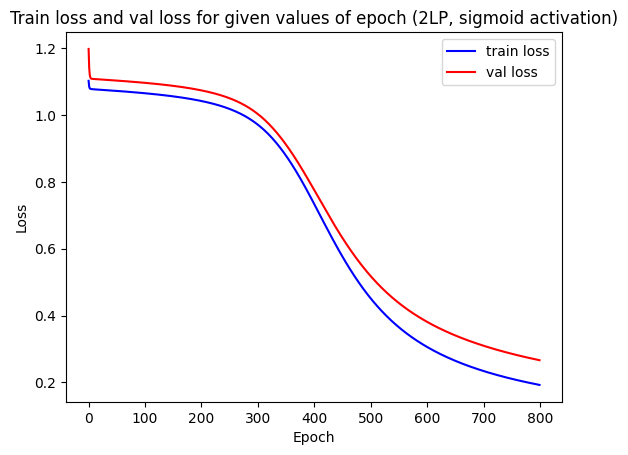

In [6]:

plt.title("Train loss and val loss for given values of epoch (2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

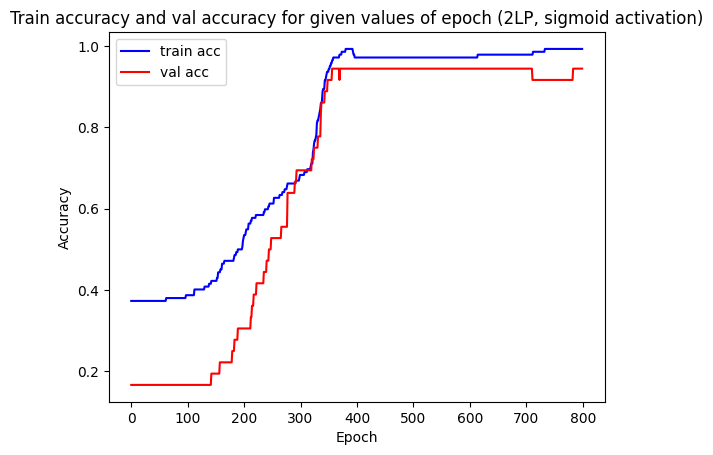

In [7]:
plt.title("Train accuracy and val accuracy for given values of epoch (2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

## 3LP


In [8]:
hidden_layers = [8, 8]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.146055086234214; val loss: 1.2850472310239278
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 50; train loss: 1.0864811761672206; val loss: 1.1071205386742087
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 100; train loss: 1.0864710635072514; val loss: 1.1071131469587945
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 150; train loss: 1.0864610128688867; val loss: 1.1071058226734711
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 200; train loss: 1.0864510217742611; val loss: 1.1070985641875266
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 250; train loss: 1.086441087867001; val loss: 1.107091369552689
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 300; train loss: 1.086431208837997; val loss: 1.1070842368662785
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 350; train loss: 1.086421382423238; val loss: 1.10707716426933

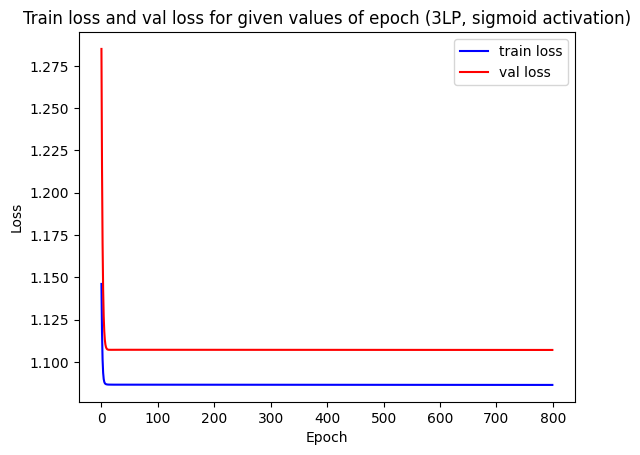

In [9]:
plt.title("Train loss and val loss for given values of epoch (3LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

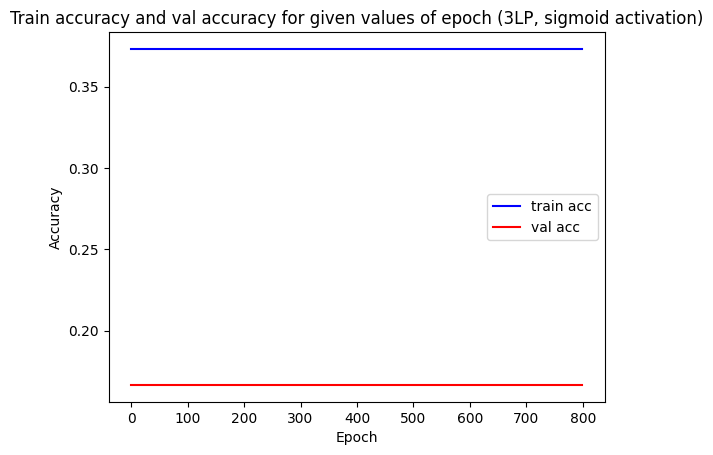

In [10]:
plt.title("Train accuracy and val accuracy for given values of epoch (3LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

vanishing gradient problem

In [11]:
hidden_layers = [8, 8]
activations = [relu] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 8.396828172622842; val loss: 4.5151536876565315
train acc: 0.2605633802816901; val acc: 0.3055555555555556

epoch: 50; train loss: 7.499690153185477; val loss: 3.5620477310502503
train acc: 0.5985915492957746; val acc: 0.7777777777777778

epoch: 100; train loss: 7.261893303782206; val loss: 3.4061583150783385
train acc: 0.6056338028169014; val acc: 0.8055555555555556

epoch: 150; train loss: 7.086104851414536; val loss: 3.3142580282413867
train acc: 0.6056338028169014; val acc: 0.8055555555555556

epoch: 200; train loss: 6.94126003020006; val loss: 3.242418726842183
train acc: 0.6056338028169014; val acc: 0.8055555555555556

epoch: 250; train loss: 6.806113854753013; val loss: 3.170083452877076
train acc: 0.6056338028169014; val acc: 0.8055555555555556

epoch: 300; train loss: 6.674891809793211; val loss: 3.1042661601650554
train acc: 0.6056338028169014; val acc: 0.8055555555555556

epoch: 350; train loss: 6.54808689009629; val loss: 3.0433768435068647
train acc: 

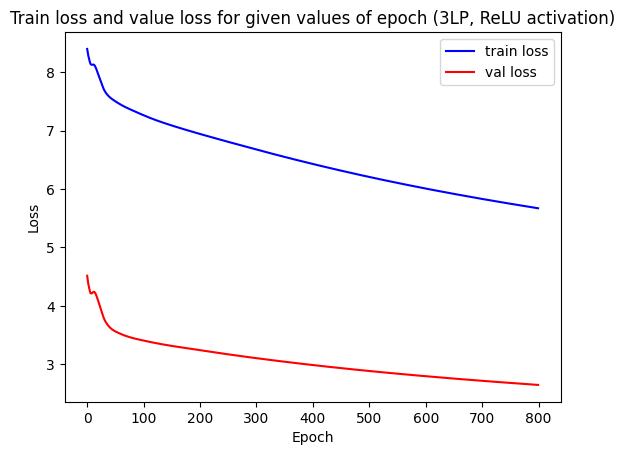

In [12]:
plt.title("Train loss and value loss for given values of epoch (3LP, ReLU activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

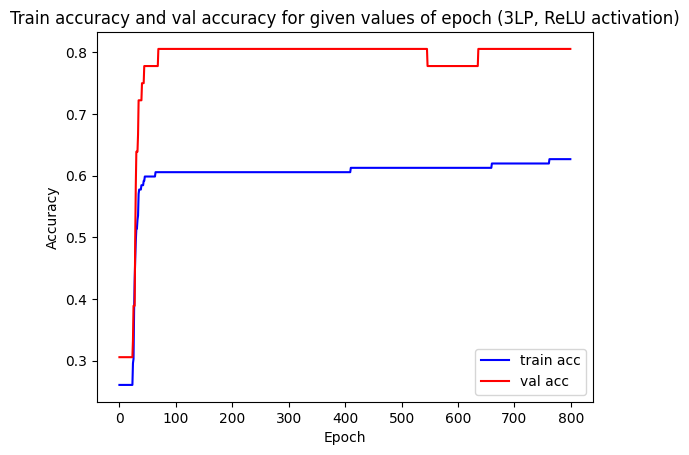

In [13]:
plt.title("Train accuracy and val accuracy for given values of epoch (3LP, ReLU activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

so relu was a solution to the vanishing gradient problem


*In deep neural networks, the vanishing gradient problem is a phenomenon where the gradients of the parameters with respect to the loss function become very small, leading to slow or stalled training. It is particularly common in networks with many layers, such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs).

The problem arises because the gradients are multiplied by the weights during backpropagation, and if the weights are small, then the gradients will also be small. This can make it difficult for the network to learn, since the weight updates will be very small and may not be able to overcome the initial randomness of the weights.

There are several ways to address the vanishing gradient problem, including using better weight initialization techniques, using non-linear activation functions such as ReLU, and using techniques such as skip connections and batch normalization.

It is possible that using more than one hidden layer in your perceptron is causing the vanishing gradient problem, leading to poor performance. The vanishing gradient problem is more likely to occur in deeper networks, where there are many layers, so using a single hidden layer may be sufficient for your task.

There could be other factors contributing to the difference in performance as well. For example, the number of units in the hidden layer and the choice of activation function could also impact the network's ability to learn. It is worth experimenting with different architectures and hyperparameters to see what works best for your particular task and dataset.

In general, it is important to be mindful of the vanishing gradient problem when training deep neural networks, and to consider using techniques such as weight initialization, non-linear activation functions, and skip connections to mitigate the issue.*



# Learning rate


epoch: 0; train loss: 1.217572778974966; val loss: 1.4430480563022572
train acc: 0.3732394366197183; val acc: 0.16666666666666666

epoch: 50; train loss: 1.083920700907731; val loss: 1.121125220699407
train acc: 0.3873239436619718; val acc: 0.16666666666666666

epoch: 100; train loss: 1.082281033067298; val loss: 1.1159326013463597
train acc: 0.39436619718309857; val acc: 0.16666666666666666

epoch: 150; train loss: 1.0815336416447625; val loss: 1.1150656614754906
train acc: 0.39436619718309857; val acc: 0.16666666666666666

epoch: 200; train loss: 1.0808063598828193; val loss: 1.1143945640788167
train acc: 0.4014084507042254; val acc: 0.16666666666666666

epoch: 250; train loss: 1.0800796409251063; val loss: 1.1137364602980924
train acc: 0.4014084507042254; val acc: 0.19444444444444445

epoch: 300; train loss: 1.0793516777618075; val loss: 1.1130809322676396
train acc: 0.4225352112676056; val acc: 0.2222222222222222

epoch: 350; train loss: 1.0786215322284598; val loss: 1.112426651275

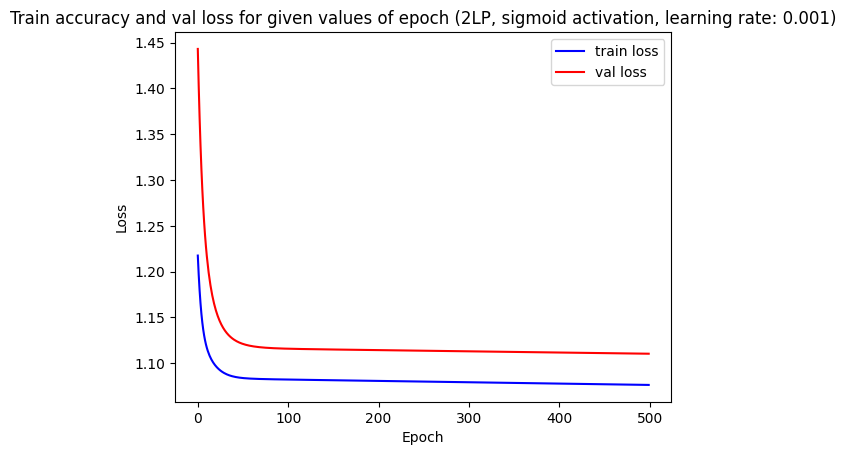

epoch: 0; train loss: 1.2165514991740534; val loss: 1.028583480311366
train acc: 0.3732394366197183; val acc: 0.5277777777777778

epoch: 50; train loss: 1.0786322647611921; val loss: 1.1039035186044293
train acc: 0.38028169014084506; val acc: 0.16666666666666666

epoch: 100; train loss: 1.073317849575354; val loss: 1.0994067933884653
train acc: 0.3873239436619718; val acc: 0.16666666666666666

epoch: 150; train loss: 1.0673271004421043; val loss: 1.0943411759374297
train acc: 0.4014084507042254; val acc: 0.16666666666666666

epoch: 200; train loss: 1.0600167198402042; val loss: 1.088206055769189
train acc: 0.4225352112676056; val acc: 0.19444444444444445

epoch: 250; train loss: 1.0502847749539748; val loss: 1.080156073663182
train acc: 0.4295774647887324; val acc: 0.2777777777777778

epoch: 300; train loss: 1.035950400542869; val loss: 1.0685490586559965
train acc: 0.4647887323943662; val acc: 0.3055555555555556

epoch: 350; train loss: 1.0123143739644038; val loss: 1.0499276635165504

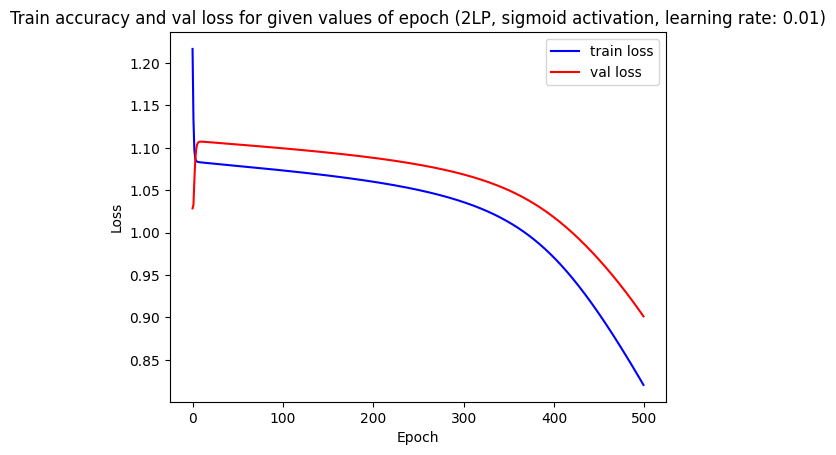

epoch: 0; train loss: 1.1352836700061149; val loss: 1.146469597916529
train acc: 0.2605633802816901; val acc: 0.3055555555555556

epoch: 50; train loss: 0.853106605861779; val loss: 0.8552327936333598
train acc: 0.8591549295774648; val acc: 0.8611111111111112

epoch: 100; train loss: 0.17908162355830626; val loss: 0.2650398503875271
train acc: 0.9929577464788732; val acc: 0.9444444444444444

epoch: 150; train loss: 0.10220343647316354; val loss: 0.17704494031712226
train acc: 0.9929577464788732; val acc: 0.9722222222222222

epoch: 200; train loss: 0.07328721366691424; val loss: 0.14341882162464897
train acc: 1.0; val acc: 0.9722222222222222

epoch: 250; train loss: 0.0574407774129805; val loss: 0.12528306794313918
train acc: 1.0; val acc: 0.9722222222222222

epoch: 300; train loss: 0.047421332961962215; val loss: 0.11389938768655866
train acc: 1.0; val acc: 0.9444444444444444

epoch: 350; train loss: 0.04054063966205233; val loss: 0.10613168495394441
train acc: 1.0; val acc: 0.94444444

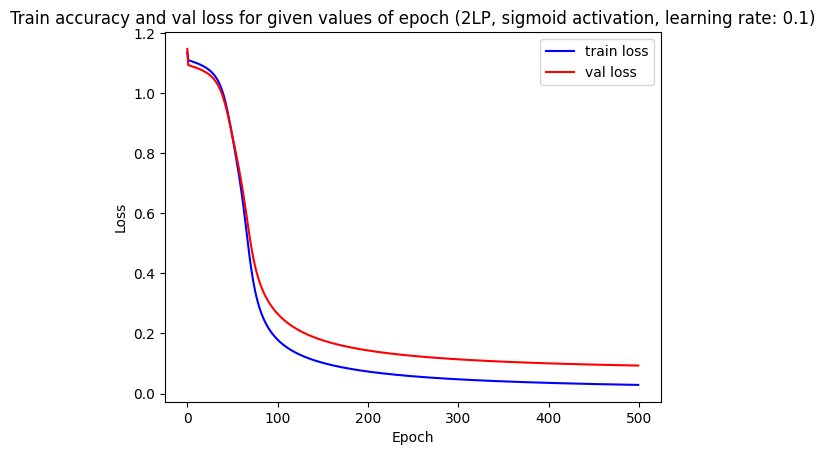

epoch: 0; train loss: 1.2107538728416163; val loss: 1.13267460193422
train acc: 0.2605633802816901; val acc: 0.3055555555555556

epoch: 50; train loss: 0.05719803096295108; val loss: 0.12394725671447136
train acc: 1.0; val acc: 0.9722222222222222

epoch: 100; train loss: 0.02831270230633361; val loss: 0.09635119371318406
train acc: 1.0; val acc: 0.9722222222222222

epoch: 150; train loss: 0.020175920829492967; val loss: 0.08967640010766229
train acc: 1.0; val acc: 0.9722222222222222

epoch: 200; train loss: 0.01620191405836715; val loss: 0.08733600348699683
train acc: 1.0; val acc: 0.9722222222222222

epoch: 250; train loss: 0.013775847730608764; val loss: 0.08658537735500166
train acc: 1.0; val acc: 0.9722222222222222

epoch: 300; train loss: 0.01211529736868303; val loss: 0.0865292403258791
train acc: 1.0; val acc: 0.9722222222222222

epoch: 350; train loss: 0.010894862677232572; val loss: 0.08680910257609402
train acc: 1.0; val acc: 0.9722222222222222

epoch: 400; train loss: 0.0099

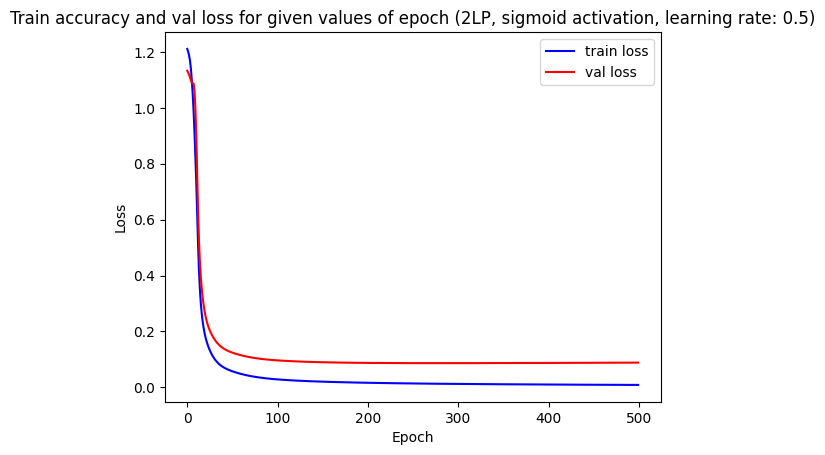

epoch: 0; train loss: 1.1644764559208711; val loss: 1.0889151177621772
train acc: 0.2605633802816901; val acc: 0.3055555555555556

epoch: 50; train loss: 0.023279844480988104; val loss: 0.0784138429494411
train acc: 1.0; val acc: 1.0

epoch: 100; train loss: 0.012740004641377041; val loss: 0.08296631041351556
train acc: 1.0; val acc: 0.9722222222222222

epoch: 150; train loss: 0.009774724474257796; val loss: 0.08266637971192156
train acc: 1.0; val acc: 0.9722222222222222

epoch: 200; train loss: 0.008145029314814102; val loss: 0.0829245718641797
train acc: 1.0; val acc: 0.9722222222222222

epoch: 250; train loss: 0.00708545513642406; val loss: 0.08344479256952236
train acc: 1.0; val acc: 0.9722222222222222

epoch: 300; train loss: 0.006329522436991592; val loss: 0.08406360243065726
train acc: 1.0; val acc: 0.9722222222222222

epoch: 350; train loss: 0.005757195295022263; val loss: 0.08471083590143465
train acc: 1.0; val acc: 0.9722222222222222

epoch: 400; train loss: 0.005305541565215

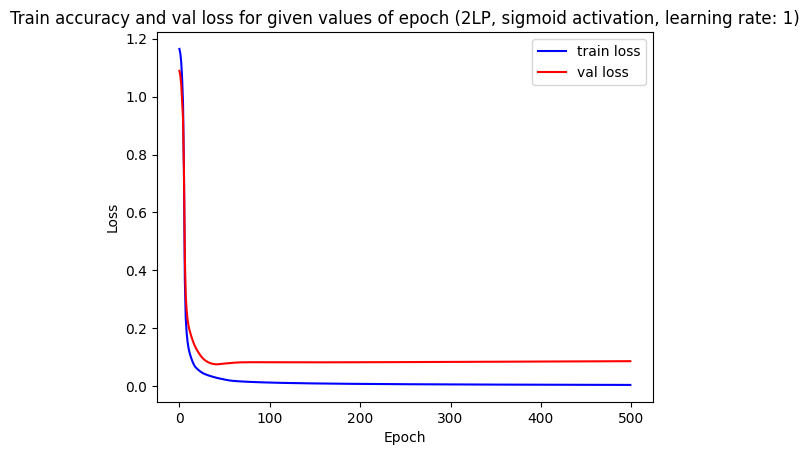

In [14]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

i = 1
for x in [.001, .01, .1, .5, 1]:
    perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
    perceptron.train(X_train, y_train, X_test, y_test, learning_rate=x, epochs=500)
    plt.figure(i)
    plt.title(f"Train accuracy and val loss for given values of epoch (2LP, sigmoid activation, learning rate: {x})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
    plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
    plt.legend()
    plt.show()
    i += 1

In case of the highest learning rate (1) we can observe the phenomenon of overfitting. The higher epoch, the higher val los is, while train loss remains the same.

# Activation functions comparison (classification)

epoch: 0; train loss: 0.000328814622821732; val loss: 0.0003254593285048895
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 50; train loss: 0.00037694209237999516; val loss: 0.0003701263061612236
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 100; train loss: 0.00044797945940412844; val loss: 0.000435770020083964
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 150; train loss: 0.0005660030407143687; val loss: 0.0005444041750019732
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 200; train loss: 0.0008086869495790237; val loss: 0.0007670572295291435
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 250; train loss: 0.0016454145474013835; val loss: 0.001533077563640065
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 300; train loss: 0.3480046333067067; val loss: 0.3177767126008544
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 350; train loss: 0.36313896352

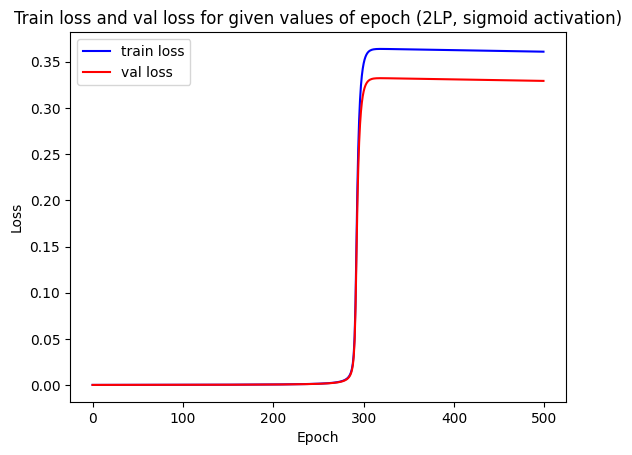

epoch: 0; train loss: 1.246213106516076; val loss: 1.2153344520752558
train acc: 0.3380281690140845; val acc: 0.3055555555555556

epoch: 50; train loss: 1.0766982220286945; val loss: 1.064525453974067
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 100; train loss: 1.0698147612261135; val loss: 1.0567885843678246
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 150; train loss: 1.061047718554693; val loss: 1.0471653802816991
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 200; train loss: 1.0484779199013317; val loss: 1.0336985717771874
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 250; train loss: 1.0276047021136583; val loss: 1.0118927386910763
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 300; train loss: 0.986670458371225; val loss: 0.9702996537335955
train acc: 0.5070422535211268; val acc: 0.5833333333333334

epoch: 350; train loss: 0.9037942822397482; val loss: 0.8884639264746217
tra

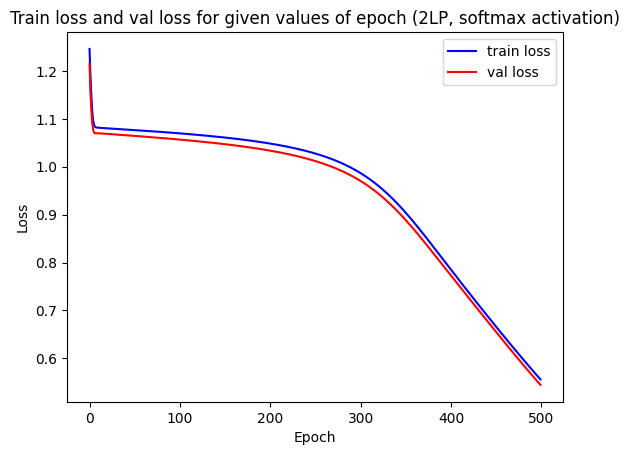

In [27]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [sigmoid]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train loss and val loss for given values of epoch (2LP, sigmoid classifier)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train loss and val loss for given values of epoch (2LP, softmax classifier)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

It is observable, that Softmax is the best choice for classification. Sigmoid breaks the network and is unable to perform effectively. 

# Amounts and widths of layers comparison


epoch: 0; train loss: 0.0010088245788256274; val loss: 0.0009357005079493585
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 50; train loss: 0.0016179749993418908; val loss: 0.0014824641240951683
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 100; train loss: 0.0043794551705022885; val loss: 0.003958328285757845
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 150; train loss: 0.7161026218872891; val loss: 0.6501921635449481
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 200; train loss: 0.7136189185837268; val loss: 0.6475672464835778
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 250; train loss: 0.7072336178340458; val loss: 0.6413581925563384
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 300; train loss: 0.6997609640221883; val loss: 0.6340926509043011
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 350; train loss: 0.6903891093671087; val loss: 0

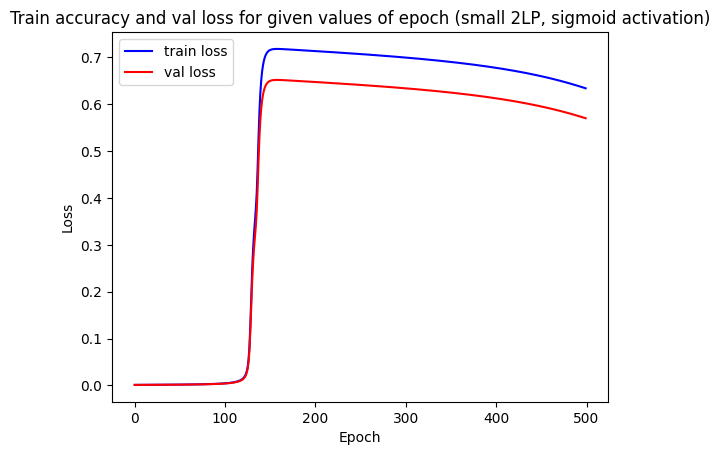

epoch: 0; train loss: 1.1716937925492865; val loss: 1.157303505820086
train acc: 0.3380281690140845; val acc: 0.3055555555555556

epoch: 50; train loss: 1.0890116754362344; val loss: 1.0752962572217688
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 100; train loss: 1.089011675433947; val loss: 1.0752962572315414
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 150; train loss: 1.08901167543166; val loss: 1.075296257241314
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 200; train loss: 1.0890116754293724; val loss: 1.0752962572510878
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 250; train loss: 1.0890116754270849; val loss: 1.0752962572608622
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 300; train loss: 1.089011675424797; val loss: 1.0752962572706368
train acc: 0.3873239436619718; val acc: 0.4444444444444444

epoch: 350; train loss: 1.089011675422509; val loss: 1.0752962572804128
train 

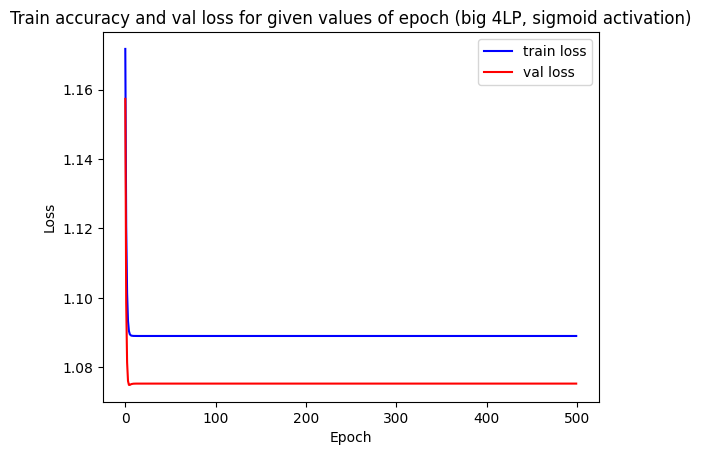

In [24]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train accuracy and val loss for given values of epoch (small 2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

hidden_layers = [32, 16, 16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train accuracy and val loss for given values of epoch (big 4LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

In case of layers amounts and hidden layers widths, overfitting phenomenon is observable while using too big networks. Smaller network performs significantly better than the bigger one and eventually reaches smaller losses.